In [1]:
import tensorflow as tf
print(tf.__version__)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!python -m wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv -o daily-min-temperatures.csv


Saved under daily-min-temperatures (1).csv


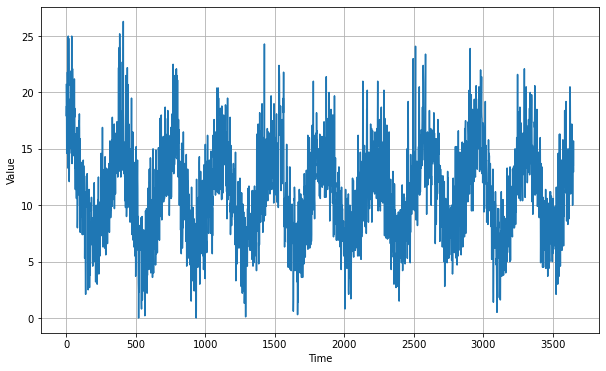

In [4]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter=',')

    next(reader)
    step = 1
    for row in reader:
        time_step.append(step)
        step += 1
        temps.append(float(row[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [17]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))  # given [1, 2, 3, 4, 5], we are predicting [2, 3, 4, 5, 6]
    return ds.batch(batch_size).prefetch(1)


In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
# tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

# window_size = 8
# batch_size = 1

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [16]:
# for i, j in train_set:
#     print(i.shape, j.shape)
#     print(i.numpy(), j.numpy())
#     print('######################')
#     break

(1, 8, 1) (1, 8, 1)
[[[15.5]
  [16.7]
  [16.3]
  [15.1]
  [12.7]
  [10. ]
  [11.4]
  [12.6]]] [[[16.7]
  [16.3]
  [15.1]
  [12.7]
  [10. ]
  [11.4]
  [12.6]
  [10.7]]]
######################


In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 4s 89ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 1s 86ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 1s 74ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 1s 83ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 1s 89ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 1s 83ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 1s 87ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 1s 86ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 1s 89ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [==============================] - 1s 89ms/step - loss: 13.6448 - mae: 14.1371
Epoch 11/100
10/10 [=========

10/10 [==============================] - 1s 93ms/step - loss: 12.7658 - mae: 13.2655
Epoch 86/100
10/10 [==============================] - 1s 101ms/step - loss: 14.3696 - mae: 14.8695
Epoch 87/100
10/10 [==============================] - 1s 92ms/step - loss: 16.1099 - mae: 16.6099
Epoch 88/100
10/10 [==============================] - 1s 92ms/step - loss: 18.3041 - mae: 18.8041
Epoch 89/100
10/10 [==============================] - 1s 92ms/step - loss: 20.3890 - mae: 20.8890
Epoch 90/100
10/10 [==============================] - 1s 79ms/step - loss: 23.1757 - mae: 23.6757
Epoch 91/100
10/10 [==============================] - 1s 82ms/step - loss: 25.8163 - mae: 26.3163
Epoch 92/100
10/10 [==============================] - 1s 92ms/step - loss: 29.2931 - mae: 29.7931
Epoch 93/100
10/10 [==============================] - 1s 107ms/step - loss: 32.7202 - mae: 33.2202
Epoch 94/100
10/10 [==============================] - 1s 109ms/step - loss: 36.9080 - mae: 37.4079
Epoch 95/100
10/10 [==========

(1e-08, 0.0001, 0.0, 60.0)

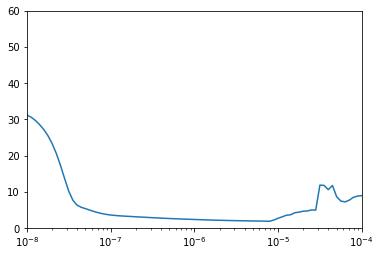

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [22]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, 1]),
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.Dense(30, activation="relu"),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 400)
# ])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# previous, lr is not found
# ----------------------------------------------------------------------
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)



Epoch 1/200
25/25 [==============================] - 5s 73ms/step - loss: 5.3534 - mae: 5.8344
Epoch 2/200
25/25 [==============================] - 2s 73ms/step - loss: 2.3160 - mae: 2.7769
Epoch 3/200
25/25 [==============================] - 2s 74ms/step - loss: 1.8909 - mae: 2.3449
Epoch 4/200
25/25 [==============================] - 2s 72ms/step - loss: 1.8459 - mae: 2.2981
Epoch 5/200
25/25 [==============================] - 2s 73ms/step - loss: 1.7896 - mae: 2.2405
Epoch 6/200
25/25 [==============================] - 2s 73ms/step - loss: 1.7443 - mae: 2.1939
Epoch 7/200
25/25 [==============================] - 2s 72ms/step - loss: 1.7030 - mae: 2.1513
Epoch 8/200
25/25 [==============================] - 2s 72ms/step - loss: 1.6822 - mae: 2.1295
Epoch 9/200
25/25 [==============================] - 2s 72ms/step - loss: 1.6837 - mae: 2.1317
Epoch 10/200
25/25 [==============================] - 2s 72ms/step - loss: 1.6506 - mae: 2.0970
Epoch 11/200
25/25 [=============================

25/25 [==============================] - 2s 71ms/step - loss: 1.4989 - mae: 1.9405
Epoch 86/200
25/25 [==============================] - 2s 74ms/step - loss: 1.5019 - mae: 1.9437
Epoch 87/200
25/25 [==============================] - 2s 73ms/step - loss: 1.5102 - mae: 1.9523
Epoch 88/200
25/25 [==============================] - 2s 72ms/step - loss: 1.5053 - mae: 1.9473
Epoch 89/200
25/25 [==============================] - 2s 75ms/step - loss: 1.4984 - mae: 1.9398
Epoch 90/200
25/25 [==============================] - 2s 69ms/step - loss: 1.4931 - mae: 1.9342
Epoch 91/200
25/25 [==============================] - 2s 78ms/step - loss: 1.4921 - mae: 1.9331
Epoch 92/200
25/25 [==============================] - 2s 74ms/step - loss: 1.4966 - mae: 1.9380
Epoch 93/200
25/25 [==============================] - 3s 95ms/step - loss: 1.4954 - mae: 1.9364
Epoch 94/200
25/25 [==============================] - 3s 96ms/step - loss: 1.4927 - mae: 1.9337
Epoch 95/200
25/25 [==============================] -

25/25 [==============================] - 2s 86ms/step - loss: 1.4763 - mae: 1.9159
Epoch 170/200
25/25 [==============================] - 2s 84ms/step - loss: 1.4835 - mae: 1.9234
Epoch 171/200
25/25 [==============================] - 2s 72ms/step - loss: 1.4787 - mae: 1.9184
Epoch 172/200
25/25 [==============================] - 2s 70ms/step - loss: 1.4740 - mae: 1.9135
Epoch 173/200
25/25 [==============================] - 2s 76ms/step - loss: 1.4772 - mae: 1.9167
Epoch 174/200
25/25 [==============================] - 2s 84ms/step - loss: 1.4779 - mae: 1.9178
Epoch 175/200
25/25 [==============================] - 2s 85ms/step - loss: 1.4801 - mae: 1.9199
Epoch 176/200
25/25 [==============================] - 2s 84ms/step - loss: 1.4779 - mae: 1.9174
Epoch 177/200
25/25 [==============================] - 2s 84ms/step - loss: 1.4747 - mae: 1.9140
Epoch 178/200
25/25 [==============================] - 2s 84ms/step - loss: 1.4728 - mae: 1.9120
Epoch 179/200
25/25 [=======================

In [23]:

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

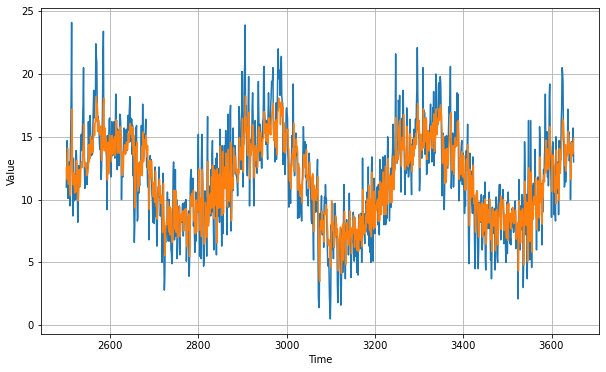

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8065618

In [26]:

print(rnn_forecast)

[12.520325 11.646849 13.053298 ... 13.622787 13.805789 14.882445]
